In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_log_error

In [2]:
# Import data
train = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/train.csv'
df_train_raw = pd.read_csv(train)

test_x = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/test.csv'
df_test_x_raw = pd.read_csv(test_x)

test_y = 'https://raw.githubusercontent.com/ss16318/AML_Group_3/main/sample_submission.csv'
df_test_y_raw= pd.read_csv(test_y)

In [3]:
# Merge train dataset and test dataset
df_test_raw = pd.merge(df_test_x_raw, df_test_y_raw, on='Id')
df_raw = pd.concat([df_train_raw,df_test_raw])


In [4]:
df_raw

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.000000
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.000000
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.000000
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.000000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,167081.220949
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,164788.778231
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,219222.423400
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal,184924.279659


In [5]:
# In the data description, missing values(nan) for those features are indicated None
na_none = ['Alley','BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu', 
     'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature']

In [6]:
# check percentage of missing data for each feature in train dataset
na_col = [i for i in df_raw.columns if df_raw[i].isnull().sum() > 0 and i not in na_none]
print((df_raw[na_col].isna().sum()/len(df_raw.Id)).sort_values())

BsmtUnfSF       0.000343
GarageCars      0.000343
KitchenQual     0.000343
Electrical      0.000343
TotalBsmtSF     0.000343
GarageArea      0.000343
BsmtFinSF2      0.000343
SaleType        0.000343
Exterior2nd     0.000343
Exterior1st     0.000343
BsmtFinSF1      0.000343
BsmtFullBath    0.000685
BsmtHalfBath    0.000685
Utilities       0.000685
Functional      0.000685
MSZoning        0.001370
MasVnrArea      0.007879
MasVnrType      0.008222
GarageYrBlt     0.054471
LotFrontage     0.166495
dtype: float64


In [7]:
def clean_df(df):
    for col in df.columns:
        if col in na_none:
            df[col] =  df[col].fillna('None')
        elif df[col].isnull().sum() / df.shape[0] > 0.1:
            df = df.drop(col, axis=1)
        elif df[col].isnull().sum() / df.shape[0] <= 0.1:
            df = df.dropna(subset=[col])
    return df

In [8]:
df = clean_df(df_raw)
df = df.drop('Id', axis=1)

In [9]:
# split the dataset
df_x = df.drop(columns='SalePrice')
df_y = df['SalePrice']

In [10]:
## Seb Encoding, Correlation and Clustering

#List categorical features
categorical_feats = df_x.select_dtypes('object').columns
categorical_feats

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [11]:
# Encode variables

# Target Encode features that have many groups / are not ordinal
target_cat_feats = ['GarageType', 'Functional', 'Electrical', 'SaleCondition', 'SaleType', 'Heating', 'BsmtFinType2', 'BsmtFinType1', 'Foundation', 'MSZoning', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType']
target_encoder = ce.TargetEncoder(cols=target_cat_feats)

target_encoder.fit(df_x, df_y)
df_x_te = target_encoder.transform(df_x)

# Ordinal Encode features with few groups / have a natural order
ordinal_cat_feats = ['FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'Alley', 'KitchenQual', 'PavedDrive', 'GarageCond', 'GarageQual', 'GarageFinish', 'CentralAir', 'HeatingQC', 'BsmtExposure', 'BsmtCond', 'BsmtQual', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LandSlope', 'ExterQual', 'ExterCond']
ordinal_encoder = ce.OrdinalEncoder(cols=ordinal_cat_feats)

ordinal_encoder.fit(df_x_te, df_y)
df_x_encoded = ordinal_encoder.transform(df_x_te)

In [12]:
# Sort Data Chronologically (preventing data leakage)
df_x_encoded = df_x_encoded.reset_index(drop=True)
df_y = df_y.reset_index(drop=True)

# Sort df_x_encoded by YearSold
df_x_sorted = df_x_encoded.sort_values(by='YrSold')

# Set the index of df_y to match the sorted index of df_x_sorted
df_y_sorted = df_y.loc[df_x_sorted.index]

In [13]:

# Split Data into Dev and Test
X_dev, X_test, y_dev, y_test = train_test_split(df_x_sorted, df_y_sorted, test_size=0.2, shuffle=False)

# Split Dev into Train and Test
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.2, shuffle=False)

In [14]:
#Scale Data
scale = StandardScaler()
X_train_scaled = scale.fit_transform(X_train)
X_val_scaled = scale.transform(X_val)
X_test_scaled = scale.fit_transform(X_test)

### PCA (Ilan)

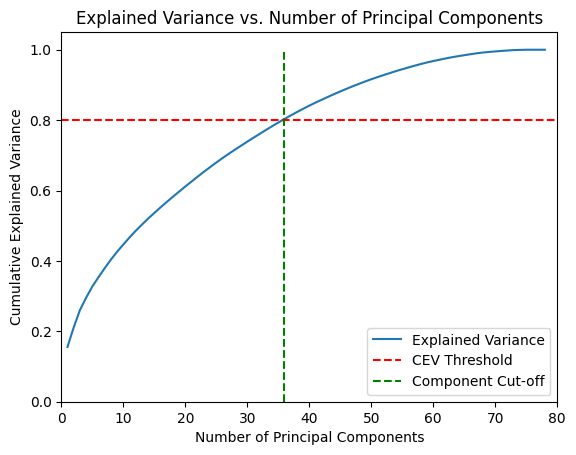

In [15]:
from sklearn.decomposition import PCA

#Apply PCA to scaled data and compute the variance ratio:
pca = PCA()
pca.fit(X_train_scaled)
explained_variance_ratio = pca.explained_variance_ratio_

#Plot the explained variance ratio as a function of the number of principal components:
plt.plot(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), label='Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.hlines(y=0.8, xmin=0, xmax=80, linestyles='dashed', colors='red', label='CEV Threshold')
plt.vlines(x=36, ymin=0, ymax=1, linestyles='dashed', colors='green', label='Component Cut-off')
plt.xlim((0,80))
plt.ylim((0,1.05))
plt.legend(loc='lower right')
plt.title('Explained Variance vs. Number of Principal Components')
plt.show()

In [16]:
#Determine the number of PC that explain a sufficient proportion of the variance
n_components = np.where(np.cumsum(explained_variance_ratio) >= 0.80)[0][0] + 1

In [17]:
#Perform PCA with the optimal number of principal components:
pca_optimal = PCA(n_components=n_components)

X_train_pca = pca_optimal.fit_transform(X_train_scaled)
X_val_pca = pca_optimal.fit_transform(X_val_scaled)
X_test_pca = pca_optimal.fit_transform(X_test_scaled)

In [18]:
# Create a DataFrame with principal components and columns named 'PC1', 'PC2', etc.
df_principal_components = pd.DataFrame(X_train_pca, columns=['PC' + str(i + 1) for i in range(n_components)])
df_principal_components

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36
0,2.434799,0.679084,1.675042,-1.014937,1.047598,0.964453,-1.244467,-1.123356,0.603929,1.173682,...,0.027037,0.632286,0.368175,0.127338,-1.274546,-0.455147,1.260681,0.037785,-1.253242,0.737669
1,-3.282260,-0.557763,-1.479180,-0.950597,-0.564162,2.761905,0.566260,0.684537,-0.218827,0.862705,...,-0.368352,-0.539123,-1.845794,1.396676,-0.610967,0.522615,0.220625,-1.175226,-0.714169,1.478104
2,3.240690,-1.633768,1.900784,-1.645005,0.143106,-0.068620,0.028909,-0.198588,0.174121,-0.377138,...,0.584800,0.182416,-0.292824,-0.453171,0.080664,0.398932,0.016342,0.027385,-0.064684,0.248150
3,-1.099794,0.347799,-1.021251,-0.532778,-0.611853,0.395954,-0.314879,1.157711,-0.901222,-0.007497,...,0.775886,-0.247311,0.535817,0.299246,0.895405,-0.309056,-0.647205,0.335873,-1.251562,-0.355402
4,-0.045694,0.514285,1.552383,0.189235,0.214842,1.498005,-0.057590,0.086184,-0.415826,-0.422894,...,1.394033,-0.642536,-0.561445,0.777798,-0.175987,-0.483436,-0.286464,0.280829,0.632752,1.302915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1739,-1.476119,1.302474,3.138618,-2.395876,0.275096,-2.275773,-0.977511,-1.095002,1.795364,1.875855,...,0.190321,-4.367309,-1.170975,-1.343913,0.310132,5.118836,-0.397442,-0.021836,-0.974588,1.648771
1740,0.011757,1.776977,-1.110972,-1.302754,-0.206970,0.143737,0.273455,1.171225,-0.061978,-0.413455,...,-0.917706,-0.378397,-0.212876,-0.187617,1.597862,-0.964063,-1.228464,1.891068,-0.919988,0.162895
1741,-4.785573,-0.576572,0.257004,2.451206,-0.466549,-1.264727,0.674097,-1.819785,1.796418,-0.416827,...,0.302437,0.872024,-0.712320,-1.497100,1.517831,-0.796379,0.048982,-0.343915,0.172954,0.302913
1742,-4.320473,-0.006946,0.576149,3.212694,-0.283785,-2.743433,3.320682,-5.265273,0.263871,-4.070203,...,-1.983741,-2.006675,0.083654,1.254400,-3.885145,-2.806443,-0.814785,-1.228734,-2.631363,0.721731


## Numan - Applying ML Techniques

### Random Forest on original data

In [43]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rfr_pipe = make_pipeline(RandomForestRegressor())
parameters = {
    'randomforestregressor__n_estimators': [100, 200, 500],
    'randomforestregressor__max_depth': [3,4,5],
}

rfr_grid = GridSearchCV(rfr_pipe, parameters, n_jobs=5, cv=5, verbose=1, refit=True)
rfr_grid.fit(X_train, y_train)

print(f"Best parameters: {rfr_grid.best_params_}")
y_pred_rfr_base = rfr_grid.predict(X_test)
print('Root Mean Squared Error (RMSE):', mean_squared_error(y_test, y_pred_rfr_base, squared=False))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'randomforestregressor__max_depth': 3, 'randomforestregressor__n_estimators': 100}
Root Mean Squared Error (RMSE): 41175.243067127965


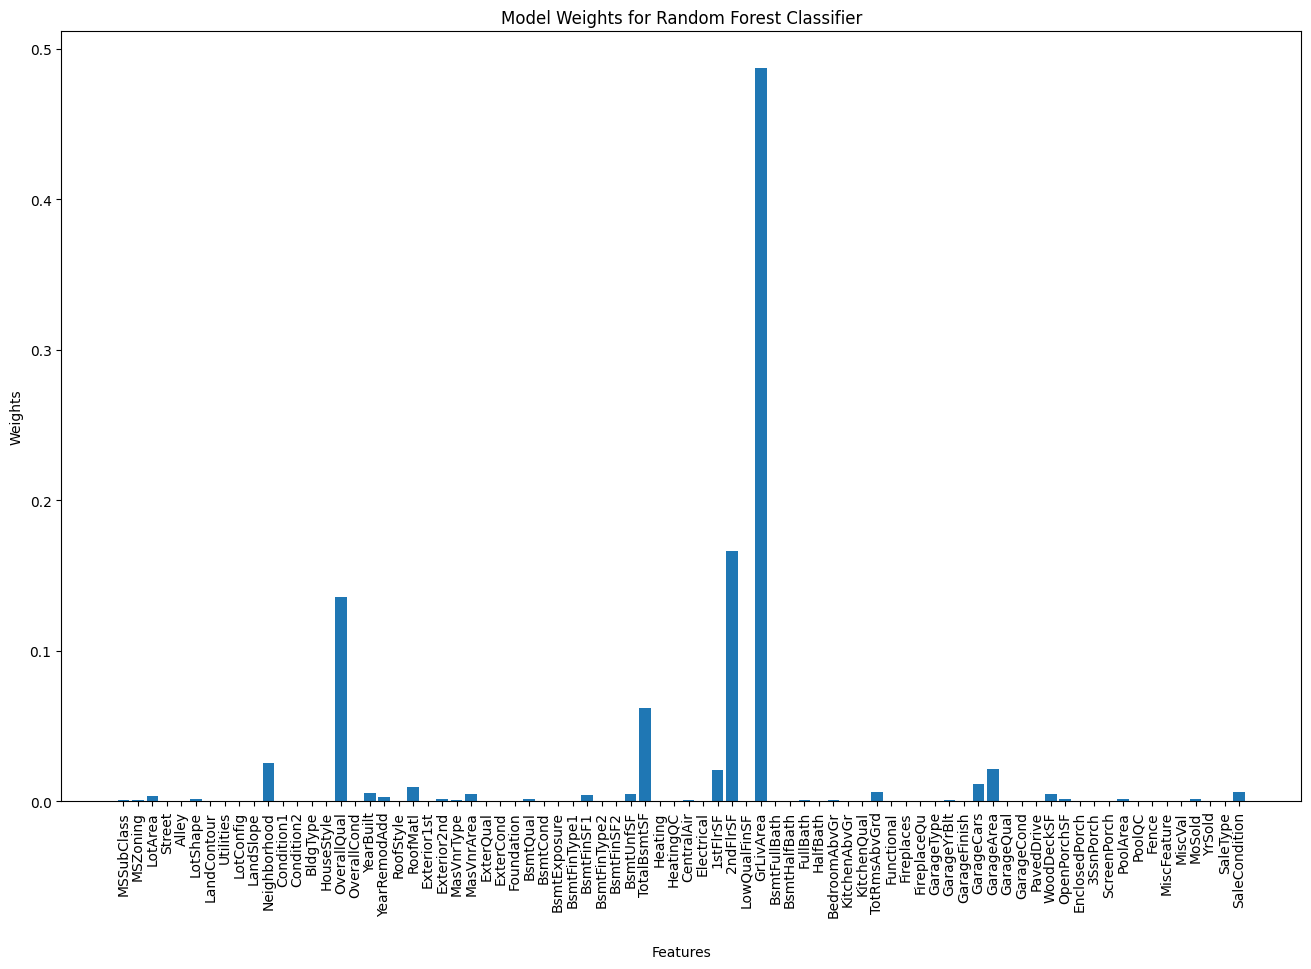

<Figure size 5000x5000 with 0 Axes>

In [51]:
rfr_tuned_importance = rfr_grid.best_estimator_.named_steps['randomforestregressor'].feature_importances_

fig = plt.figure(figsize=(16,10))
plt.bar(df_x.columns.to_list(),rtc_tuned_importance)
plt.xlabel('Features',labelpad = 20)
plt.ylabel("Weights")
plt.title('Model Weights for Random Forest Classifier')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()

### Random Forest on PCA

In [44]:
rfr_pipe_pca = make_pipeline(RandomForestRegressor())
rfr_grid_pca = GridSearchCV(rfr_pipe_pca, parameters, n_jobs=5, cv=5, verbose=1, refit=True)
rfr_grid_pca.fit(X_train_pca, y_train)

print(f"Best parameters: {rfr_grid_pca.best_params_}")
y_pred_rfr_pca = rfr_grid_pca.predict(X_test_pca)
print('Root Mean Squared Error (RMSE):', mean_squared_error(y_test, y_pred_rfr_pca, squared=False))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best parameters: {'randomforestregressor__max_depth': 4, 'randomforestregressor__n_estimators': 500}
Root Mean Squared Error (RMSE): 73509.08382170217


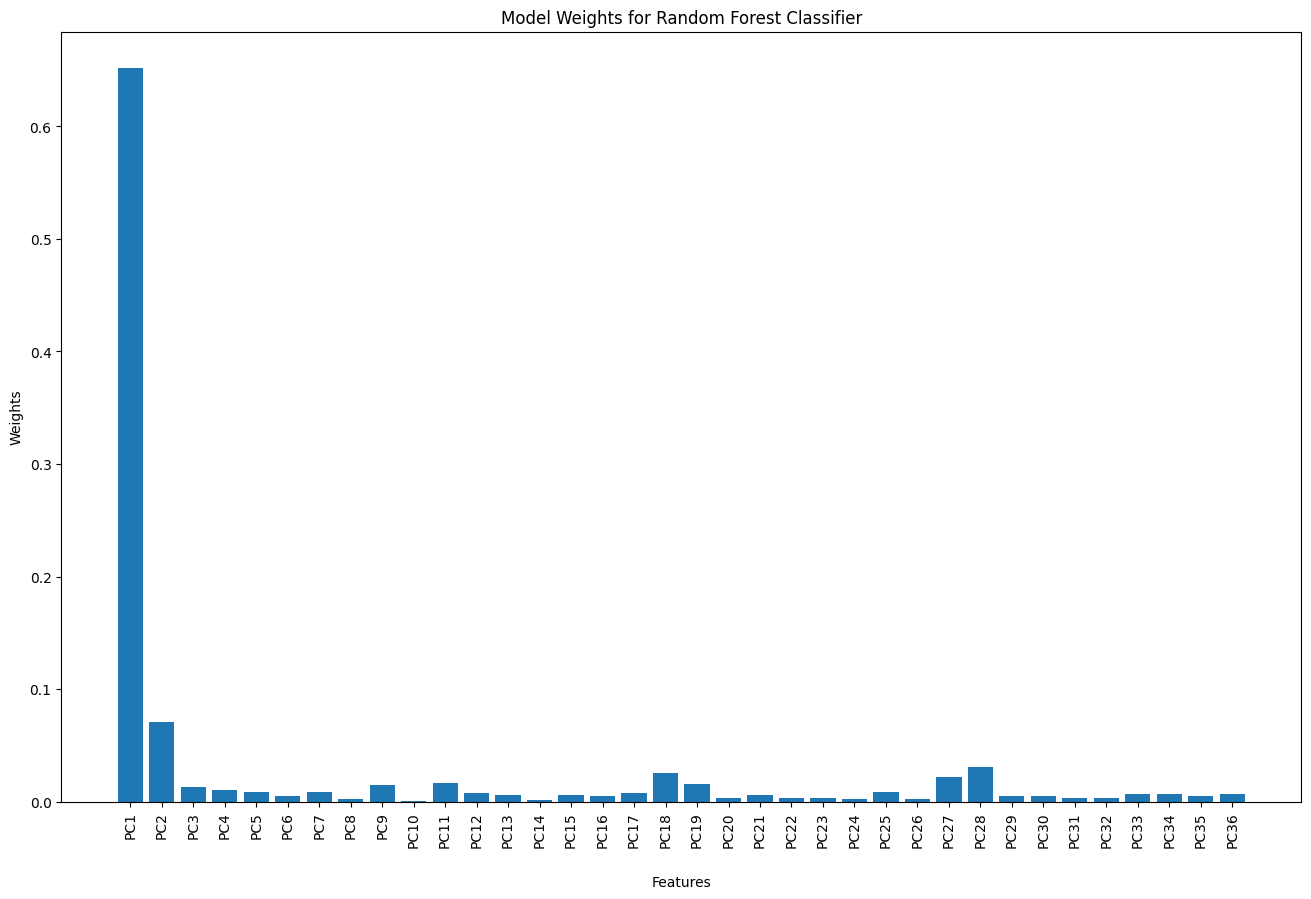

<Figure size 5000x5000 with 0 Axes>

In [55]:
pca_columns=['PC' + str(i + 1) for i in range(n_components)]
rfr_pca_tuned_importance = rfr_grid_pca.best_estimator_.named_steps['randomforestregressor'].feature_importances_

fig = plt.figure(figsize=(16,10))
plt.bar(pca_columns,rfr_pca_tuned_importance)
plt.xlabel('Features',labelpad = 20)
plt.ylabel("Weights")
plt.title('Model Weights for Random Forest Classifier')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()

### XGBoost on original data

In [33]:
from xgboost import XGBRegressor
from sklearn.pipeline import make_pipeline

xgb_pipe = make_pipeline(XGBRegressor())
parameters = {
    'xgbregressor__n_estimators': [100, 200, 500],
    'xgbregressor__learning_rate': [0.01, 0.1, 1],
    'xgbregressor__max_depth': [3,4,5],
}

xgb_grid = GridSearchCV(xgb_pipe, parameters, n_jobs=5, cv=5, verbose=1, refit=True)
xgb_grid.fit(X_train, y_train)

print(f"Best parameters: {xgb_grid.best_params_}")
xgbc_y_pred = xgb_grid.predict(X_test)
print('Root Mean Squared Error (RMSE):', mean_squared_error(y_test, xgbc_y_pred, squared=False))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'xgbregressor__learning_rate': 0.01, 'xgbregressor__max_depth': 3, 'xgbregressor__n_estimators': 500}
Root Mean Squared Error (RMSE): 39439.71009695685


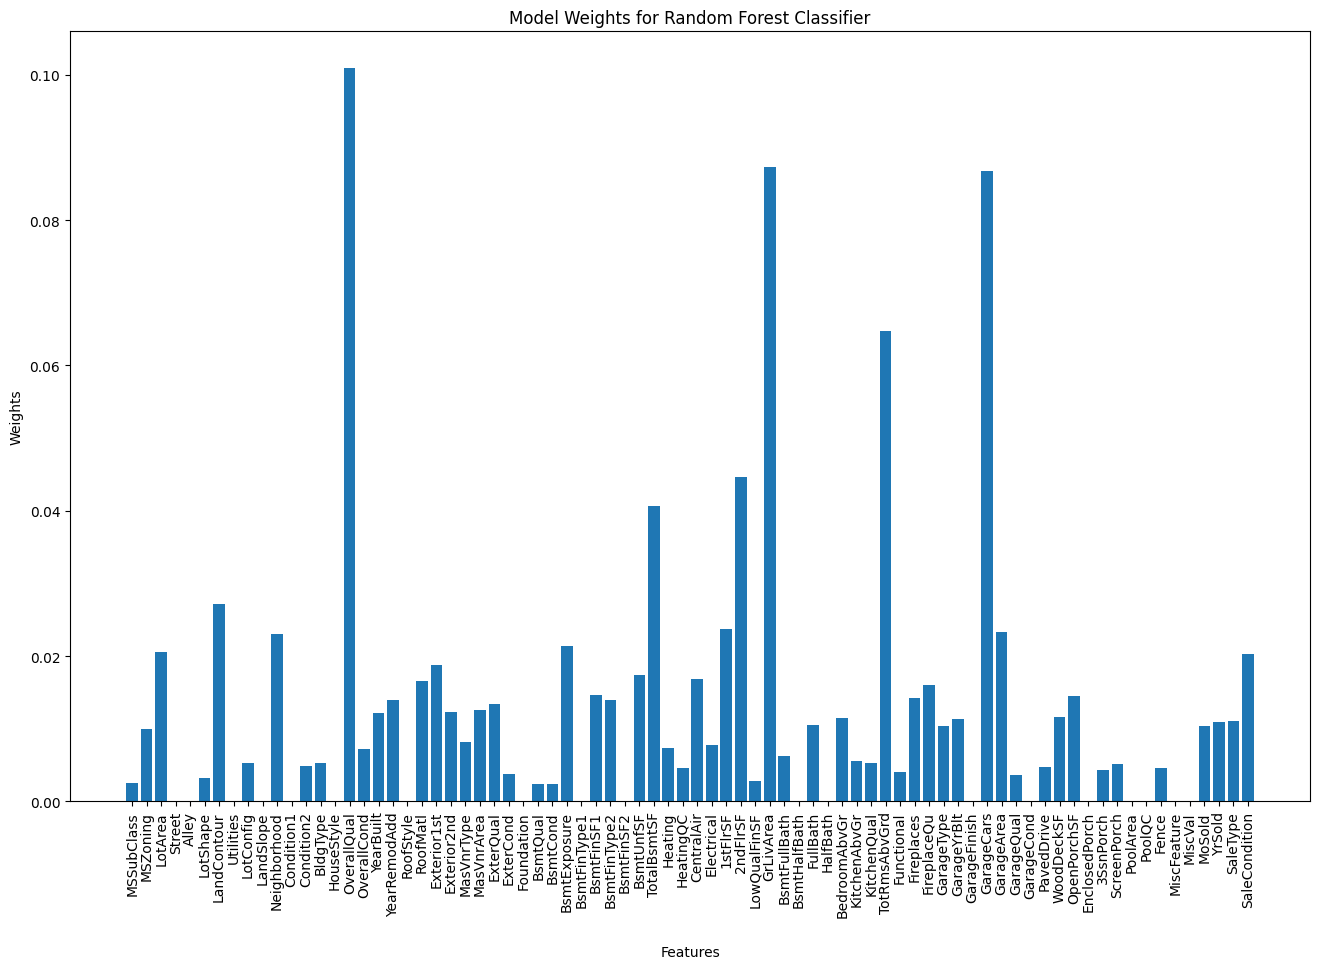

<Figure size 5000x5000 with 0 Axes>

In [52]:
xgb_tuned_importance = xgb_grid.best_estimator_.named_steps['xgbregressor'].feature_importances_

fig = plt.figure(figsize=(16,10))
plt.bar(df_x.columns.to_list(),xgb_tuned_importance)
plt.xlabel('Features',labelpad = 20)
plt.ylabel("Weights")
plt.title('Model Weights for Random Forest Classifier')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()

### XGBoost on PCA

In [36]:
xgb_pipe_pca = make_pipeline(XGBRegressor())

xgb_grid_pca = GridSearchCV(xgb_pipe, parameters, n_jobs=5, cv=5, verbose=1, refit=True)
xgb_grid_pca.fit(X_train_pca, y_train)

print(f"Best parameters: {xgb_grid_pca.best_params_}")
xgbc_y_pred_pca = xgb_grid_pca.predict(X_test_pca)
print('Root Mean Squared Error (RMSE):', mean_squared_error(y_test, xgbc_y_pred_pca, squared=False))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters: {'xgbregressor__learning_rate': 0.01, 'xgbregressor__max_depth': 4, 'xgbregressor__n_estimators': 500}
Root Mean Squared Error (RMSE): 72099.73702745335


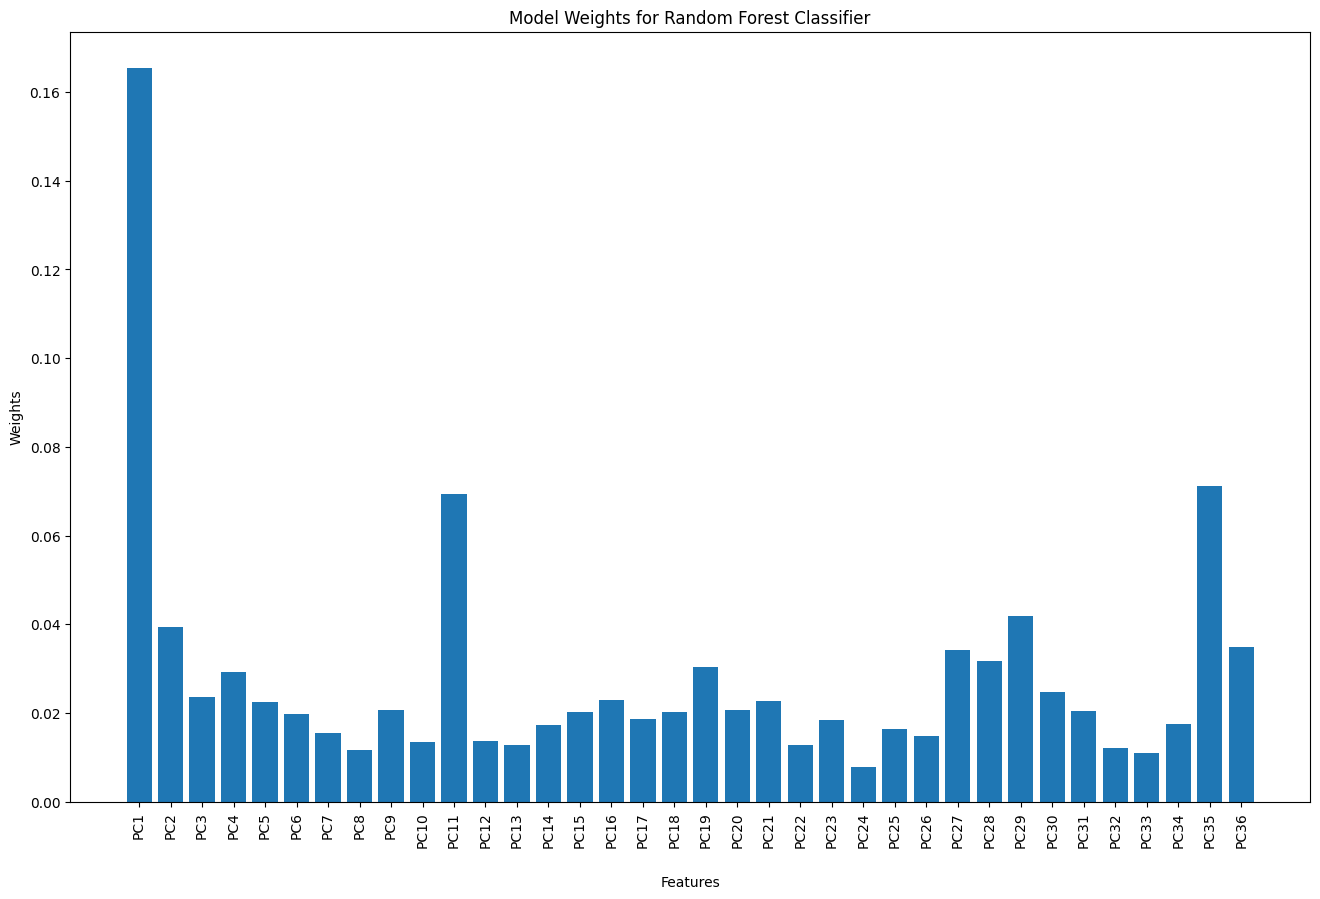

<Figure size 5000x5000 with 0 Axes>

In [57]:
xgb_pca_tuned_importance = xgb_grid_pca.best_estimator_.named_steps['xgbregressor'].feature_importances_

fig = plt.figure(figsize=(16,10))
plt.bar(pca_columns,xgb_pca_tuned_importance)
plt.xlabel('Features',labelpad = 20)
plt.ylabel("Weights")
plt.title('Model Weights for Random Forest Classifier')
plt.xticks(rotation=90)
plt.figure(figsize=(50,50))
plt.show()